# Case Study 1: Hydrologic models of soil physical processes from the NWM and TOPMODEL

The Sleepers River Research Watershed (SRRW) in Vermont is an active hydrologic research site since 1959 and was the setting where Dunne and Black (1970) determined the controls of saturation-excess overland flow (SOF) on streamflow generation.

This jupyter notebook has code cells to:
1. Load data for use in R and Python scripts
2. Create a historical time series and magnitude percentile plots for simulated data
3. Generate a priori and a posteriori parameter distribution plots via Approximate Bayesian Computation
4. Compute Sobol first-order, delta, and OLS sensitivity indices
5. Produce portrait, scatter, and spider plots

To complete and visualize a comprehensive sensitivity analysis on the SWMM simulations, we use packages from both R and Python. This command allows us to run R scripts in the Python jupyter notebook.

In [1]:
%load_ext rpy2.ipython

Now we load the model simulation data, observation/truth data, parameter sets, time stamps, and objective function values into Python as data frames using the pandas library.

In [2]:
import pandas as pd

sim = pd.read_csv("input/simulation_ts.csv", index_col = 0)
pars = pd.read_csv("input/params.csv", header = 0)
OF = pd.read_csv("input/OF_values.csv")
obs = pd.read_csv("input/observation_ts.csv")

### 2. Approximate Bayesian Computation
One method integrated into the workflow was Approximate Bayesian Computation (ABC), which represents the combination of model parameter values that maximize the probability of representing the observed data. ABC applies [Bayesian theory](https://en.wikipedia.org/wiki/Bayes%27_theorem) to parameter spaces to estimate posterior distributions of model parameters. ABC is advantageous because it bypasses calculating the likelihood function by using the model simulations compared to the observed data ([Engeland and Gottschalk 2002](https://www.hydrol-earth-syst-sci.net/6/883/2002/), [Kavetski et al. 2006](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005WR004368), [Sunnåker et al. 2013](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002803), [Vrugt and Sadegh 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20354)). The steps to compute ABC are: 1) Calculate the observed data’s statistics (e.g. mean, standard deviation) and choose model specific objective functions (e.g. NSE). 2) Assume a uniform sampling interval for the parameter space. Draw a total of n parameters from prior and simulate the model for each of the parameter points, this results in n sequences of simulated data. 3) Calculate objective functions for each sequence of simulated data. 4) Determine the distance between the observed and simulated transition frequencies for all parameter points. Remove parameter points beyond a user specified tolerance interval (e.g. NSE ≥ 0.0) to approximate samples from the posterior distribution. 5) Estimate the posterior distribution with the parameter points within the tolerance interval ([Sunnåker et al. 2013](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002803), [Vrugt and Sadegh 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20354)). 

For the python script below, specify the number of model runs, tolerance of the objective functions, number of histogram bins and the figure colors. Here we used pre-defined objective functions, but the code can be modified to calculate a variety of objective functions. The plots produced are histograms of the various parameters illustrating the difference between original modeled output and the ABC constrained parameter sets.

In [ ]:
# %load approx_bayes_calc_of_defined.py 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

'''
Approximate Baysian Calculation requires:
    1) observation dataset (df_obs)
    2) parameter sets (df_parms)
    3) model output (df_model)
    4) objective functions (df_OFs)
    5) tolerance
    6) number of model runs
'''

def approx_bayes_calc_OF(parms,OFs,simulations):
    keep_nse = []
    for i in np.arange(simulations):
        # User can redefine tolerance and OF here
        if OFs.iloc[i,0] >= tolerance_nse:
            keep_nse.append(parms.iloc[i])        
    return keep_nse

def make_histograms(df_parms,bayes_approx,bins,alpha,cc1,cc2,parameters,metric):
    plt.figure(figsize=(15,12))
    gridsize = math.ceil((np.sqrt((df_parms.iloc[0,:]).size))) # graph columns
    
    for col in np.arange(1,((df_parms.iloc[0,:]).size)+1):
        plt.subplot(gridsize-1,gridsize,col)
        ax = df_parms.iloc[:,col-1].plot.hist(bins=bins,alpha=alpha,color=cc1,linewidth=4)    
        ax = bayes_approx.iloc[:,col-1].plot.hist(bins=bins,alpha=alpha,color=cc2,linewidth=4)
        ax.set_xlabel(str(parameters[col-1]))    
    plt.legend(['Output','ABC'],fancybox=True)
    plt.tight_layout() 
    plt.savefig('output/plots/ABC/'+metric+'_histogram.png',dpi=1000)

def make_cdfs_pdfs(df_parms,bayes_approx,bins,alpha,cc1,cc2,parameters,metric):
    plt.figure(figsize=(15,12))
    gridsize = math.ceil((np.sqrt((df_parms.iloc[0,:]).size)))
    
    for col in np.arange(1,((df_parms.iloc[0,:]).size)+1):
        plt.subplot(gridsize-1,gridsize,col)
        ax = df_parms.iloc[:,col-1].plot.hist(cumulative=True, density=1,bins=bins,alpha=alpha,color=cc1,linewidth=4)    
        ax = bayes_approx.iloc[:,col-1].plot.hist(cumulative=True, density=1,bins=bins,alpha=alpha,color=cc2,linewidth=4)
        ax.set_xlabel(str(parameters[col-1]))    
    plt.legend(['Output','ABC'],fancybox=True)
    plt.tight_layout() 
    plt.savefig('output/plots/ABC/'+metric+'_cdf.png',dpi=1000)
    
    plt.figure(figsize=(15,12))
    gridsize = math.ceil((np.sqrt((df_parms.iloc[0,:]).size)))
    
    for col in np.arange(1,((df_parms.iloc[0,:]).size)+1):
        plt.subplot(gridsize-1,gridsize,col)
        ax = df_parms.iloc[:,col-1].plot.kde(alpha=alpha,color=cc1,linewidth=4)    
        ax = bayes_approx.iloc[:,col-1].plot.kde(alpha=alpha,color=cc2,linewidth=4)
        ax.set_xlabel(str(parameters[col-1]))   
    plt.legend(['Output','ABC'],fancybox=True)
    plt.tight_layout() 
    plt.savefig('output/plots/ABC/'+metric+'_pdf.png',dpi=1000)

def runABC(df_parms,df_OFs,runs,bins,color1,color2):
    # models with objective functions within tolerance thresholds
    results_nse = np.array(approx_bayes_calc_OF(df_parms,df_OFs,runs))

    # saves models with objective functions within tolerance thresholds
    bayes_approx_nse = pd.DataFrame(results_nse,columns=None)
    bayes_approx_nse.to_csv('output/bayes_parameters_NSE.csv',index=False)
    parameters = list(df_parms.columns.values)
    
    # print ABC results and make figures
    print('precent of models with NSE >= to',str(tolerance_nse),'are:',str(len(results_nse)/runs),'%')
    make_histograms(df_parms,bayes_approx_nse,bins,0.5,color1,color2,parameters,'NSE')
    make_cdfs_pdfs(df_parms,bayes_approx_nse,bins,0.5,color1,color2,parameters,'NSE')

precent of models with NSE >= to 0.0 are: 0.4052 %


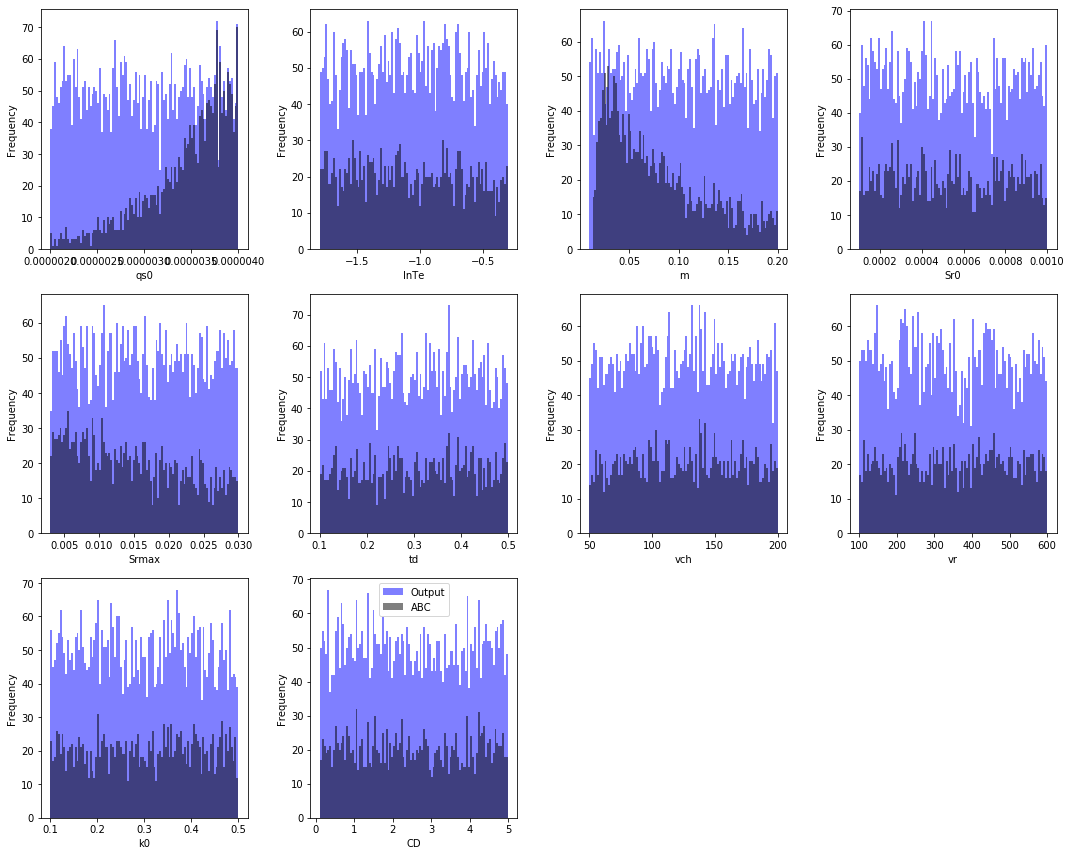

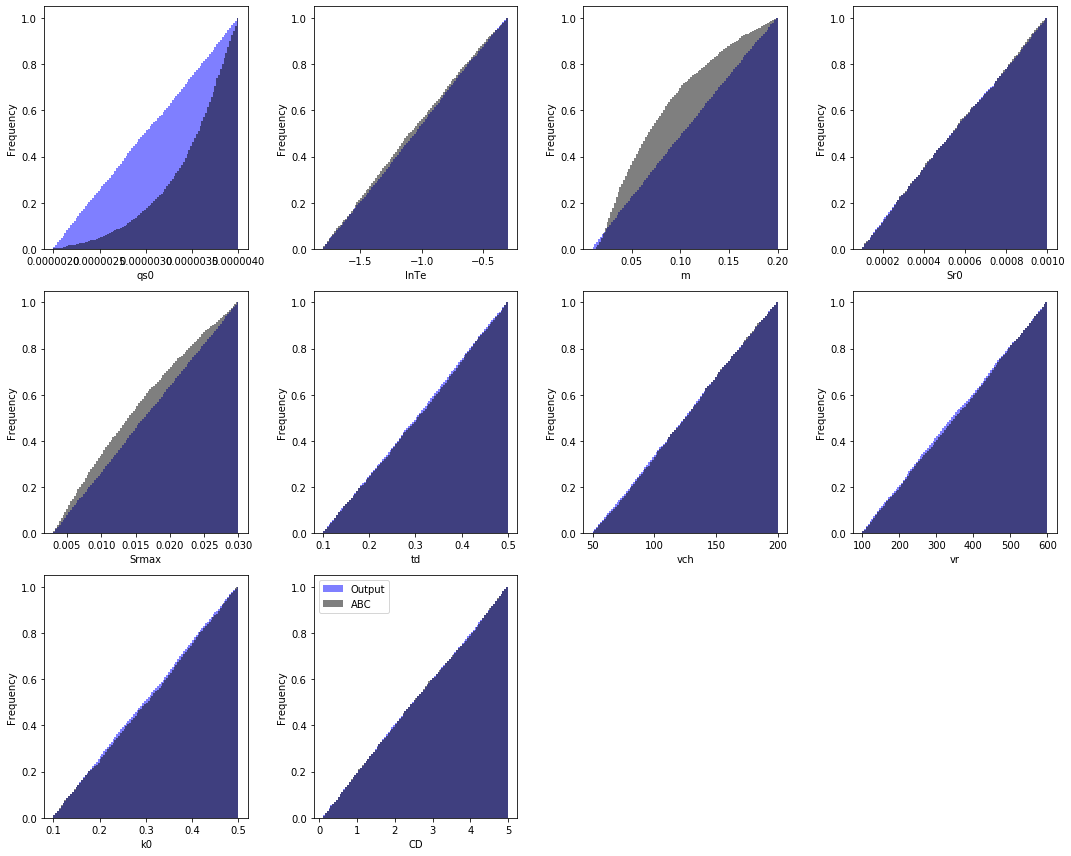

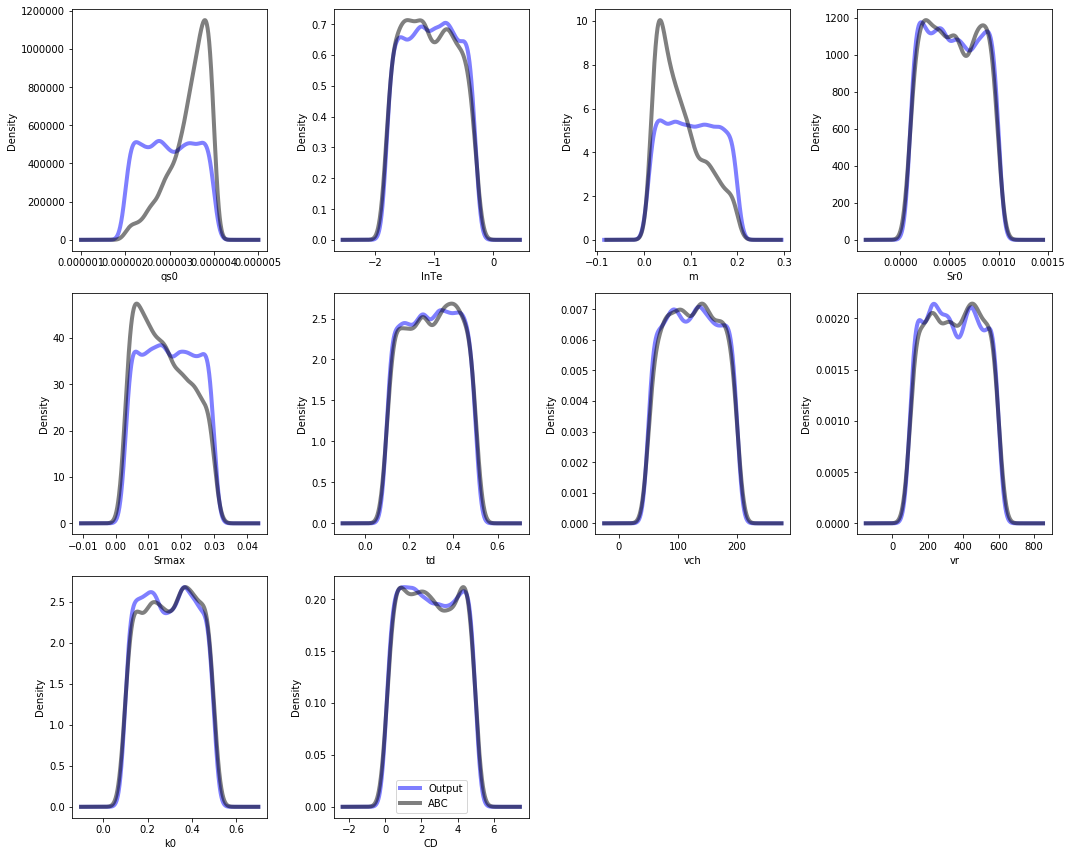

In [13]:
# Specify tolerance for objective functions (OF)
tolerance_nse = 0.0  # OF >= tolerance (NSE)

runs = 5000 # specify number of model runs
bins = 100   # specify number of histogram bins
color1 = 'b' # color of original model output
color2 = 'k' # color of 1st ABC applied to OF (NSE)

# Runs function that evaluates models outputs with approximate Bayesian computation
runABC(pars, OF, runs, bins, color1, color2)

### 3. Sensitivity Analysis
Two sensitivity analyses are incorporated into the workflow: a moment-independent sensitivity analysis and an ordinary least squares regression.

The Delta index ([Borgonovo, 2007](https://doi.org/10.1016/j.ress.2006.04.015); [Borgonovo et al., 2012](https://www.sciencedirect.com/science/article/pii/S1364815211001617?via%3Dihub); [Plischke et al., 2013](https://doi.org/10.1016/j.ejor.2012.11.047)) is a moment-independent global sensitivity analysis. While less robust than indices returned by a variance-based sensitivity analysis, a moment-independent sensitivity analysis was a popular technique due to its computational efficiency and insensitivity to dependent parameters ([Pannell, 1997](https://doi.org/10.1016/S0169-5150(96)01217-0)). The Delta sensitivity analysis searches for parameters with the greatest impact on the probability density function of model output. Delta indices capture non-linear and non-monotonic parameter-output dynamics. Lastly, the ordinary least squares (OLS) regression yields an R2 coefficient, which quantified the linear effects of model input parameters on model output variance. OLS regressions have long been employed throughout model sensitivity analyses and assume an explicit interaction between model output and any given parameter ([Kleijnen, 1995](https://doi.org/10.1002/sdr.4260110403); [Pannell, 1997](https://doi.org/10.1016/S0169-5150(96)01217-0); [Zobitz et al., 2006](https://doi.org/10.1016/j.agrformet.2006.01.003)).

To visualize objective function sensitivity to model input parameters, the following code produces radial convergence plots, scatter plots, portrait plots, and spider plots based on the outputs from the sensitivity analyses.

The Sobol and delta sensitivity indices are calculated using a modified version of the Python sensitivity analysis library ([SALib](https://salib.readthedocs.io/en/latest/index.html)) and the OLS regression is calculated using [StatsModels](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) library in Python.

In [11]:
# %load SensIndices_RCPlots.py
#!/usr/bin/env python3

# import python libraries
import pandas as pd
import os

# back out a directory to load python functions from "Scripts" folder
org_dir_name = os.path.dirname(os.path.realpath('SensIndices_RCPlots.py'))
parent_dir_name = os.path.dirname(os.path.dirname(os.path.realpath('SensIndices_RCPlots.py')))
os.chdir(parent_dir_name + "/Scripts")

# load python functions from ‘Scripts’ folder
import delta
import ols

# move back into case study 0 folder
os.chdir(org_dir_name)

# load in model parameters and OF values
pars = pd.read_csv("input/params.csv", index_col = 0)
OF = pd.read_csv("input/OF_values.csv")

# Define the model inputs
problem = {
    'num_vars': 10,
    'names': ['qs0', 'lnTe', 'm', 'Sr0', 'Srmax', 'td', 'vch', 'vr', 'k0', 'CD']

}

# save the parameter names
param_names = problem['names']

# calculate delta indices and sobol first-order indices
results_delta = []
results_delta = delta.objective_function_delta(problem, pars, OF)

# calculate R^2 from OLS regression
results_R2 = []
results_R2 = ols.objective_function_OLS(OF, pars, param_names)

ModuleNotFoundError: No module named 'SALib'

From the sensitivity analysis results (calculated and exported from python), we can create portrait plots, scatter plots, and spider plots for various objective functions and parameter values.

First, the data is loaded and formatted into a usable format and then exported to a .csv file. Then the script creates additional plots to help visualize and convey parameter sensitivity.

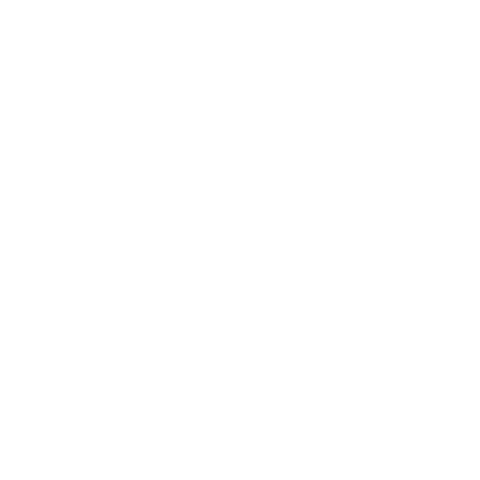

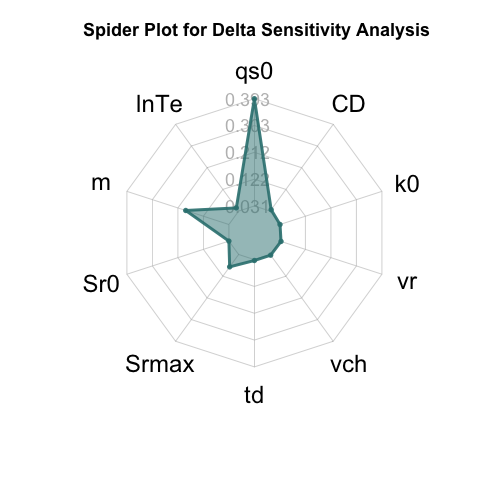

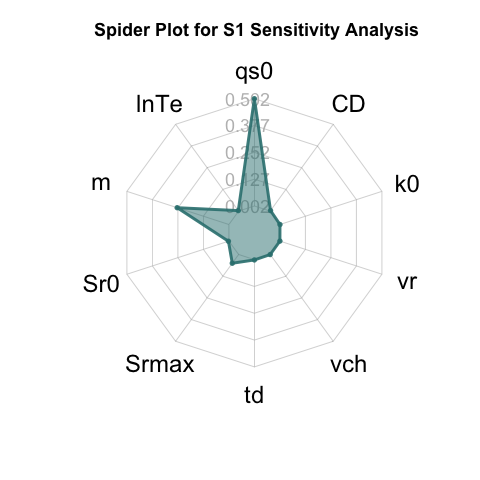

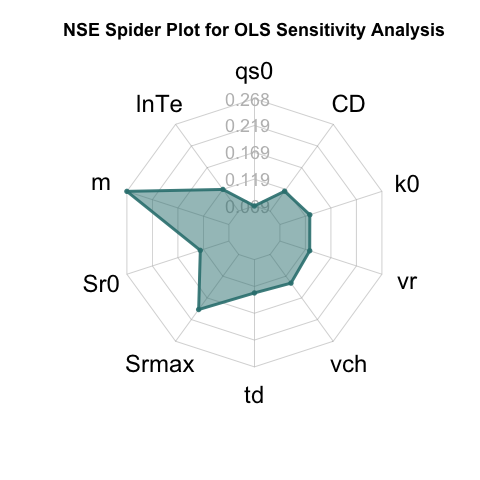

In [5]:
%%R
# %load Portrait_Scatter_Spider.R
# This script loads in data from Sobol, Delta, and OLS sensitivity analyses calculated in
# Python script for Case Study 0: Fall Creek, NY.

library(dplyr)

# load in parameter sets, objective functions, observation, simulation, and time steps
pars <- read.csv("input/params.csv", header = TRUE) %>%
  dplyr::select(-1)
  # "model_runs" rows, "num_pars" columns

OF <- read.csv("input/OF_values.csv", header = TRUE)
  # "model_runs" rows, "num_OF" columns

# save names of objective functions and parameters
OF_names <- colnames(OF)
param_names <- colnames(pars)

# set variables of number of model runs, time steps, and number of parameters
model_runs <- nrow(pars)
num_pars <- ncol(pars)
num_OF <- ncol(OF)

# load in results from delta, sobol, and ols sensitivity analyses (calculated in python script)
source("../Scripts/python_to_r_results.R")
results_delta <- python_to_r_results(data_type = "delta", param_names, OF_names)
results_ols <- python_to_r_results(data_type = "ols", param_names, OF_names)

# save as csv files
lapply(results_delta, function(x) write.table(data.frame(x), 'output/formatted_delta.csv', append = T, sep = ',' ))
lapply(results_ols, function(x) write.table(data.frame(x), 'output/formatted_ols.csv', append = T, sep = ',' ))

# scatter plots of objective functions versus parameter values
source("../Scripts/scatterplots.R")
for (i in 1:num_OF) {
  
  # subset by objective function, i
  objective_fun <- OF[, i]
  
  # create scatterplots of all parameters versus objective function, i
  par_OF_scatter(params = pars, objective_fun, OF_name = colnames(OF)[i])
  
}

# portrait plots of objective functions versus parameter values
source("../Scripts/portrait_plots.R")
portrait_plot(results_delta, "delta")
portrait_plot(results_ols, "ols")

# spiders plots of objective functions versus parameter values
source("../Scripts/spider_plots.R")
spiderplot(results_delta)
spiderplot(results_ols)